In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [48]:
df = pd.read_csv('additive_manufacturing_synthetic.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        167 non-null    float64
 1   wall_thickness      167 non-null    float64
 2   infill_density      167 non-null    int64  
 3   infill_pattern      167 non-null    object 
 4   nozzle_temperature  167 non-null    int64  
 5   bed_temperature     167 non-null    int64  
 6   print_speed         167 non-null    int64  
 7   material            167 non-null    object 
 8   fan_speed           167 non-null    int64  
 9   roughness           167 non-null    int64  
 10  tension_strength    167 non-null    int64  
 11  elongation          167 non-null    float64
dtypes: float64(3), int64(7), object(2)
memory usage: 15.8+ KB


In [49]:
cat_col = df.select_dtypes(include='object').columns.tolist()
num_col = df.select_dtypes(include='number').columns.tolist()
print(f'Catergorical Columns: {cat_col}')
print('\n')
print(f'Numerical Columns: {num_col}')

Catergorical Columns: ['infill_pattern', 'material']


Numerical Columns: ['layer_height', 'wall_thickness', 'infill_density', 'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed', 'roughness', 'tension_strength', 'elongation']


In [50]:
df = pd.get_dummies(df, cat_col, drop_first=True, dtype='int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   layer_height              167 non-null    float64
 1   wall_thickness            167 non-null    float64
 2   infill_density            167 non-null    int64  
 3   nozzle_temperature        167 non-null    int64  
 4   bed_temperature           167 non-null    int64  
 5   print_speed               167 non-null    int64  
 6   fan_speed                 167 non-null    int64  
 7   roughness                 167 non-null    int64  
 8   tension_strength          167 non-null    int64  
 9   elongation                167 non-null    float64
 10  infill_pattern_honeycomb  167 non-null    int32  
 11  material_pla              167 non-null    int32  
dtypes: float64(3), int32(2), int64(7)
memory usage: 14.5 KB


In [51]:
from sklearn.model_selection import train_test_split

df_regression = df.drop(['roughness', 'elongation'], axis=1)
X = df_regression.drop('tension_strength', axis=1)
y = df_regression['tension_strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [177]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

col_transformer = ColumnTransformer(transformers=[('num', StandardScaler(), ['layer_height', 
                                                                             'wall_thickness', 
                                                                             'infill_density', 
                                                                             'nozzle_temperature', 
                                                                             'bed_temperature', 
                                                                             'print_speed', 
                                                                             'fan_speed'])],
                                   remainder='passthrough')

X_train_scaled = col_transformer.fit_transform(X_train)
X_test_scaled = col_transformer.transform(X_test)

In [180]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns.to_list())

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns.to_list())



print(X_train_scaled.shape)
print(X_test_scaled.shape)

(133, 9)
(34, 9)


In [182]:
X_test_scaled.isnull().sum()

layer_height                0
wall_thickness              0
infill_density              0
nozzle_temperature          0
bed_temperature             0
print_speed                 0
fan_speed                   0
infill_pattern_honeycomb    0
material_pla                0
dtype: int64

In [183]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit_transform(X,y)

array([[2.0e-02, 8.0e+00, 9.0e+01, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       [2.0e-02, 7.0e+00, 9.0e+01, ..., 2.5e+01, 1.0e+00, 0.0e+00],
       [2.0e-02, 1.0e+00, 8.0e+01, ..., 5.0e+01, 0.0e+00, 0.0e+00],
       ...,
       [4.0e-02, 2.8e+00, 7.2e+01, ..., 5.0e+01, 1.0e+00, 0.0e+00],
       [1.2e-01, 2.8e+00, 7.4e+01, ..., 7.5e+01, 0.0e+00, 1.0e+00],
       [9.0e-02, 4.3e+00, 2.6e+01, ..., 0.0e+00, 1.0e+00, 0.0e+00]])

In [184]:
scores = pd.DataFrame({'Features':X.columns,'Score':selector.scores_})
scores.sort_values('Score', ascending=False)

,Features,Score
0,layer_height,22.688858
2,infill_density,17.355252
6,fan_speed,9.227765
1,wall_thickness,9.180401
8,material_pla,4.647292
4,bed_temperature,3.143728
3,nozzle_temperature,3.140921
5,print_speed,2.455982
7,infill_pattern_honeycomb,0.153927


In [185]:
selector2 = SelectKBest(score_func=mutual_info_regression, k='all')
selector2.fit_transform(X,y)

scores2 = pd.DataFrame({'Features':X.columns,'Score':selector2.scores_})
scores2.sort_values('Score', ascending=False)

,Features,Score
8,material_pla,0.114833
3,nozzle_temperature,0.096774
6,fan_speed,0.074330
1,wall_thickness,0.073125
7,infill_pattern_honeycomb,0.051772
4,bed_temperature,0.047715
2,infill_density,0.038943
0,layer_height,0.036233
5,print_speed,0.025915


In [63]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

In [25]:
from sklearn.compose import ColumnTransformer

In [35]:
ct = ColumnTransformer(transformers = ['num', MinMaxScaler(), ['Score']],
                      remainder="passthrough")

In [42]:
scores[['Score']] = mms.fit_transform(scores[['Score']])

In [44]:
scores2[['Score']] = mms.fit_transform(scores2[['Score']])

In [48]:
overall_scores = scores.merge(scores2, on='Features', suffixes=['_f_reg', '_mutual_reg'])

overall_scores

,Features,Score_f_reg,Score_mutual_reg
0,layer_height,1.000000,0.432753
1,wall_thickness,0.400555,0.540818
2,infill_density,0.763318,0.680267
3,nozzle_temperature,0.132549,1.000000
4,bed_temperature,0.132674,0.451742
5,print_speed,0.102155,0.212890
6,fan_speed,0.402657,0.846289
7,infill_pattern_honeycomb,0.000000,0.000000
8,material_pla,0.199396,0.501393


In [53]:
overall_scores['avg_score'] = (overall_scores['Score_f_reg'] + overall_scores['Score_mutual_reg'])/2 
overall_scores.sort_values(by='avg_score', ascending=False)

,Features,Score_f_reg,Score_mutual_reg,avg_score
2,infill_density,0.763318,0.680267,0.721792
0,layer_height,1.000000,0.432753,0.716376
6,fan_speed,0.402657,0.846289,0.624473
3,nozzle_temperature,0.132549,1.000000,0.566275
1,wall_thickness,0.400555,0.540818,0.470686
8,material_pla,0.199396,0.501393,0.350394
4,bed_temperature,0.132674,0.451742,0.292208
5,print_speed,0.102155,0.212890,0.157522
7,infill_pattern_honeycomb,0.000000,0.000000,0.000000


In [186]:
from sklearn.metrics import r2_score

In [187]:
from sklearn.linear_model import LinearRegression
def lin_model(train_feature, train_target, test_feature, test_target):
    linreg = LinearRegression()
    linreg.fit(train_feature, train_target)
    y_pred = linreg.predict(test_feature)
    r2 = r2_score(test_target, y_pred)
    
    return r2

#R2 score of the model without scaling:
r2 = lin_model(X_train, y_train, X_test, y_test)
print(f'R2 score of the model without scaling the features: {r2}')

#R2 score of the model with scaling:
r2_scaled = lin_model(X_train_scaled, y_train, X_test_scaled, y_test)
print(f'R2 score of the model with scaling the features: {r2_scaled}')

R2 score of the model without scaling the features: 0.19392578073504896
R2 score of the model with scaling the features: 0.19392578073504863


In [188]:
from xgboost import XGBRegressor
import xgboost as xgb

xgb_A = XGBRegressor()

In [189]:
def xgb_model(train_feature, train_target, test_feature, test_target):
    
    xgb_A.fit(train_feature, train_target)
    y_pred_xgb = xgb_A.predict(test_feature)
    r2 = r2_score(test_target, y_pred_xgb)
    
    return r2

#R2 score of the model without scaling:
r2 = xgb_model(X_train, y_train, X_test, y_test)
print(f'R2 score of the model without scaling the features: {r2}')

#R2 score of the model with scaling:
r2_scaled = xgb_model(X_train_scaled, y_train, X_test_scaled, y_test)
print(f'R2 score of the model with scaling the features: {r2_scaled}')

R2 score of the model without scaling the features: 0.1718706615405723
R2 score of the model with scaling the features: 0.1718706615405723


In [68]:
from sklearn.model_selection import GridSearchCV

In [190]:
parameter_grid = {'booster':['gblinear', 'gbtree'],
                  'eta':[0.001, 0.01, 0.1],
                 'max_depth':np.arange(2,11,1),
                 'gamma':[1, 2, 3]}

gsc = GridSearchCV(estimator=XGBRegressor(n_estimators=4, num_boost_rounds=5),
                  param_grid=parameter_grid,
                  scoring='r2',
                  cv=3,
                  verbose=1)

gsc.fit(X_train_scaled, y_train)

print(f'best score: {gsc.best_score_}')
print(f'best parameters: {gsc.best_params_}')

Fitting 3 folds for each of 162 candidates, totalling 486 fits
best score: 0.15575990509497759
best parameters: {'booster': 'gblinear', 'eta': 0.1, 'gamma': 2, 'max_depth': 5}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 800x700 with 0 Axes>

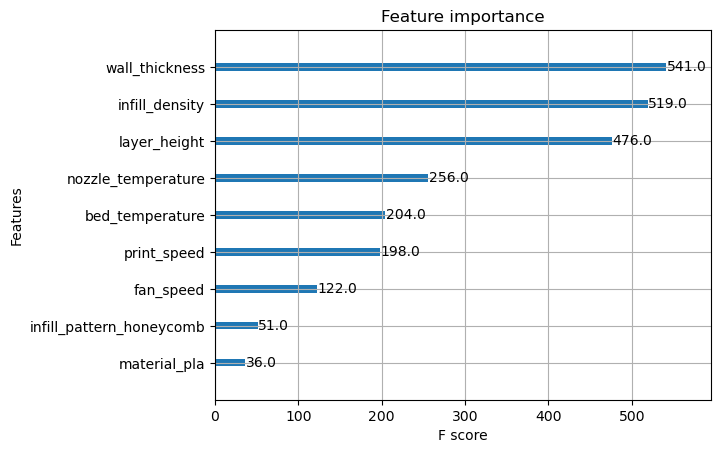

In [191]:


plt.figure(figsize=(8,7))
xgb.plot_importance(booster=xgb_A)

In [23]:
X_train_scaled = X_train_scaled.drop(['fan_speed', 'infill_pattern_honeycomb'], axis=1)
X_test_scaled = X_test_scaled.drop(['fan_speed', 'infill_pattern_honeycomb'], axis=1)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(133, 7)
(34, 7)


In [24]:
def xgb_model(train_feature, train_target, test_feature, test_target):
    
    xgb_A.fit(train_feature, train_target)
    y_pred_xgb = xgb_A.predict(test_feature)
    r2 = r2_score(test_target, y_pred_xgb)
    
    return r2

#R2 score of the model without scaling:
r2 = xgb_model(X_train, y_train, X_test, y_test)
print(f'R2 score of the model without scaling the features: {r2}')

#R2 score of the model with scaling:
r2_scaled = xgb_model(X_train_scaled, y_train, X_test_scaled, y_test)
print(f'R2 score of the model with scaling the features: {r2_scaled}')

R2 score of the model without scaling the features: 0.1718706615405723
R2 score of the model with scaling the features: 0.06289837358803474


In [25]:
parameter_grid = {'booster':['gblinear', 'gbtree'],
                  'eta':[0.001, 0.01, 0.1],
                 'max_depth':np.arange(2,11,1),
                 'gamma':[1, 2, 3]}

gsc = GridSearchCV(estimator=XGBRegressor(n_estimators=5, num_boost_rounds=50),
                  param_grid=parameter_grid,
                  scoring='r2',
                  cv=3,
                  verbose=1)

gsc.fit(X_train_scaled, y_train)

print(f'best score: {gsc.best_score_}')
print(f'best parameters: {gsc.best_params_}')

Fitting 3 folds for each of 162 candidates, totalling 486 fits
best score: 0.16474838722151952
best parameters: {'booster': 'gblinear', 'eta': 0.1, 'gamma': 1, 'max_depth': 3}


In [72]:
from sklearn.neural_network import MLPRegressor

In [192]:
mlpr = MLPRegressor(hidden_layer_sizes=(100, 50),
                    activation='tanh',
                    solver='sgd',
                    alpha=0.1,
                    learning_rate='adaptive',
                    max_iter=2000,
                    random_state=42)

mlpr.fit(X_train_scaled, y_train)
y_pred_mlpr = mlpr.predict(X_test_scaled)
score_r = r2_score(y_test, y_pred_mlpr)

print(score_r)

-0.03802274692171115


In [193]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100,
                           max_depth=10,
                           max_features=1.0,
                           min_samples_leaf=1,
                           criterion="absolute_error",
                          random_state=21)
rf.fit(X_train_scaled, y_train)
print("Random Forest R² test:", rf.score(X_test_scaled, y_test))
print("Random Forest R² train:", rf.score(X_train_scaled, y_train))

Random Forest R² test: 0.300079150542231
Random Forest R² train: 0.890841250833349


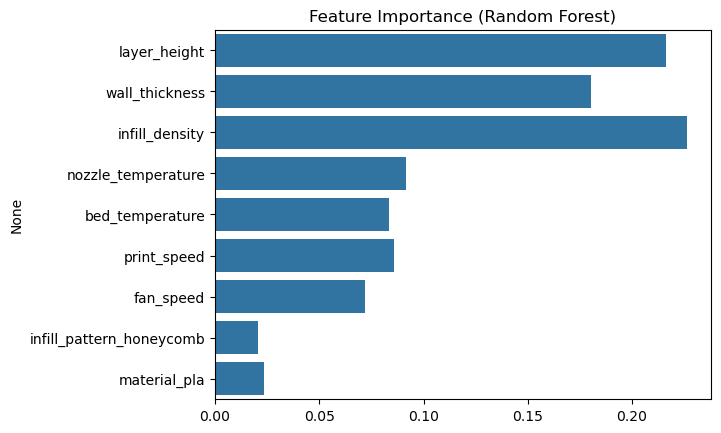

In [194]:
importances = rf.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.show()

In [200]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns.to_list())
feature_names.shape

(219,)

In [201]:
from sklearn.linear_model import LassoCV

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)


lasso = LassoCV(cv=5, max_iter=10000)
lasso.fit(X_scaled, y)


coeffs = lasso.coef_
non_zero_idx = np.where(np.abs(coeffs) > 1e-5)[0]

print("Sparse symbolic model:")
for idx in non_zero_idx:
    print(f"{coeffs[idx]:+.3f} * {feature_names[idx]}")

Sparse symbolic model:
+0.685 * wall_thickness
+0.048 * wall_thickness infill_density
+0.303 * wall_thickness nozzle_temperature
+0.002 * wall_thickness infill_pattern_honeycomb
+0.400 * layer_height wall_thickness infill_pattern_honeycomb
+3.770 * layer_height infill_density nozzle_temperature
+0.249 * layer_height infill_density bed_temperature
-0.161 * layer_height infill_pattern_honeycomb material_pla
+1.580 * wall_thickness^2 print_speed
-1.051 * wall_thickness bed_temperature fan_speed
-0.186 * wall_thickness fan_speed^2
+0.052 * wall_thickness infill_pattern_honeycomb^2
-0.028 * infill_density infill_pattern_honeycomb material_pla
-1.027 * nozzle_temperature^2 fan_speed
-0.299 * bed_temperature fan_speed^2
+2.451 * bed_temperature fan_speed material_pla
-0.728 * print_speed^3
-0.544 * print_speed fan_speed^2
-0.703 * print_speed fan_speed infill_pattern_honeycomb


In [202]:
from gplearn.genetic import SymbolicRegressor

est = SymbolicRegressor(population_size=1000, generations=30,
                        function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log'],
                        parsimony_coefficient=0.01, random_state=0)
est.fit(X_train_scaled, y_train)

print("Learned symbolic expression:")
print(est._program)


Learned symbolic expression:
div(sub(sub(sub(add(add(X1, X8), X2), -0.680), sub(-0.425, X0)), log(sub(div(X0, X0), 0.960))), sqrt(log(0.940)))


In [199]:
y_pred_est = est.predict(X_test_scaled)
print("R2:", r2_score(y_test, y_pred_est))
#print("RMSE:", mean_squared_error(y, y_pred_est, squared=False))

R2: 0.01592160176901891
